# Compare maximum margin contrastive loss with baseline model

In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

2.1.0


In [2]:
from model import *
import losses

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# global configs
EPOCHS = 20
# DATA = 'mnist'
DATA = 'fashion_mnist'
NORMALIZE_EMBEDDING = True
# NORMALIZE_EMBEDDING = False
N_DATA_TRAIN = 60000
BATCH_SIZE = 32
PROJECTION_DIM = 128
# WRITE_SUMMARY = True
WRITE_SUMMARY = False

ACTIVATION = 'leaky_relu'

In [5]:
!mkdir -p logs/

In [6]:
optimizer = tf.keras.optimizers.Adam()

# 0. Load MNIST data

In [7]:
if DATA == 'mnist':
    mnist = tf.keras.datasets.mnist
elif DATA == 'fashion_mnist':
    mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [8]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# 1. Train baseline model

In [10]:
mlp = MLP(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [11]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [13]:
@tf.function
def train_step_baseline(x, y):
    with tf.GradientTape() as tape:
        y_preds = mlp(x, training=True)
        loss = cce_loss_obj(y, y_preds)

    gradients = tape.gradient(loss, 
                              mlp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  mlp.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [14]:
@tf.function
def test_step_baseline(x, y):
    y_preds = mlp(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [15]:
model_name = 'baseline'
if not NORMALIZE_EMBEDDING:
    model_name = 'baseline-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [16]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds:
        train_step_baseline(x, y)
        
    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        

    for x_te, y_te in test_ds:
        test_step_baseline(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        

    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1.7020152807235718, Acc: 81.21666717529297, Test Loss: 1.6342310905456543, Test Acc: 83.56999969482422
Epoch 2, Loss: 1.6208746433258057, Acc: 84.51499938964844, Test Loss: 1.6415740251541138, Test Acc: 82.22000122070312
Epoch 3, Loss: 1.6064091920852661, Acc: 85.82166290283203, Test Loss: 1.612465739250183, Test Acc: 85.27999877929688
Epoch 4, Loss: 1.6001427173614502, Acc: 86.33499908447266, Test Loss: 1.6234318017959595, Test Acc: 83.87000274658203
Epoch 5, Loss: 1.5941576957702637, Ac

In [17]:
# get the projections from the last hidden layer before output
x_tr_proj = mlp.get_last_hidden(x_train)
x_tr_proj.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([60000, 256])

In [18]:
x_te_proj = mlp.get_last_hidden(x_test)
x_te_proj.shape

TensorShape([10000, 256])

In [19]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


## 1.2. Check learned embedding

In [21]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [22]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

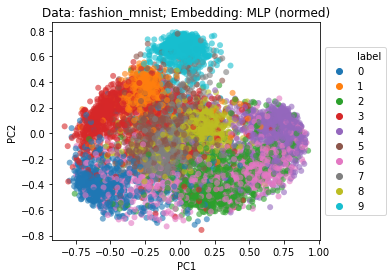

In [23]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
                    )

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: MLP'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: MLP (normed)'% DATA
ax.set_title(title);
fig.savefig('figs/PCA_plot_%s_MLP_last_layer.png' % DATA)

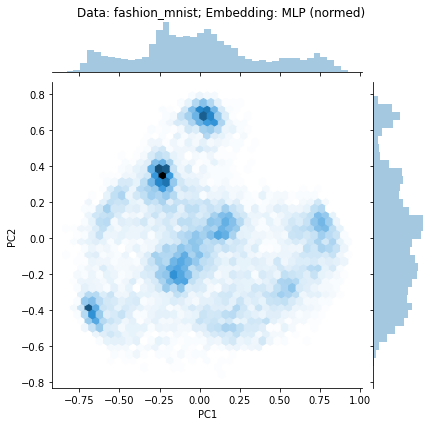

In [24]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
g.savefig('figs/Joint_PCA_plot_%s_MLP_last_layer.png' % DATA)

# 1. Supervised max margin contrastive learning

## Stage 1: train encoder with contrastive loss

In [41]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [42]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [43]:
@tf.function
# train step for the contrast loss
def train_step_contrast(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = losses.max_margin_contrastive_loss(z, y, metric='cosine')

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))

    train_loss(loss)

In [44]:
@tf.function
def test_step_contrast(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = losses.max_margin_contrastive_loss(z, y, metric='cosine')
    test_loss(t_loss)

In [45]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_bce.reset_states()
    test_loss.reset_states()
    test_bce.reset_states()

    for x, y in train_ds:
        train_step_contrast(x, y)

    for x_te, y_te in test_ds:
        test_step_contrast(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
#                         train_bce.result(),
                        test_loss.result(),
#                         test_bce.result()
                         ))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.05453260615468025, Test Loss: 0.041290223598480225
Epoch 2, Loss: 0.03690805658698082, Test Loss: 0.03629211708903313
Epoch 3, Loss: 0.03338493034243584, Test Loss: 0.03449660539627075
Epoch 4, Loss: 0.0315365269780159, Test Loss: 0.03391043469309807
Epoch 5, Loss: 0.03013443760573864, Test Loss: 0.0323902927339077
Epoch 6, Loss: 0.02895517274737358, Test Loss: 0.03133381903171539
Epoch 7, Loss: 0.027859723195433617, Test Loss: 0.030959339812397957
Epoch 8, Loss: 0.027318958193063736, T

In [46]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [47]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [48]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


## Check learned embedding

In [49]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [50]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [51]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

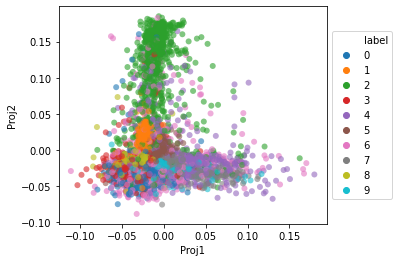

In [52]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

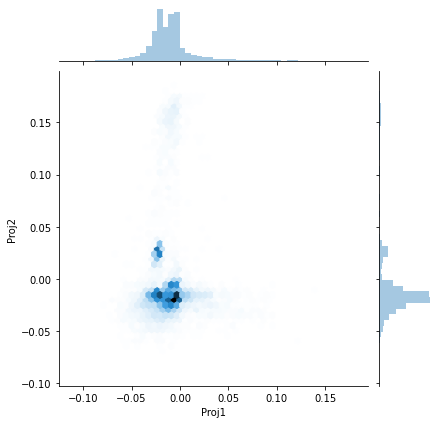

In [53]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );

In [54]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

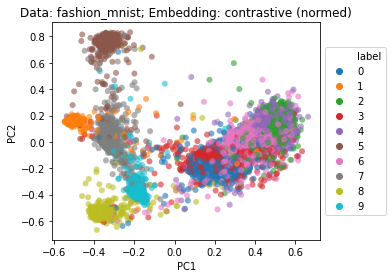

In [55]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);
fig.savefig('figs/PCA_plot_%s_contrastive_embed.png' % DATA)

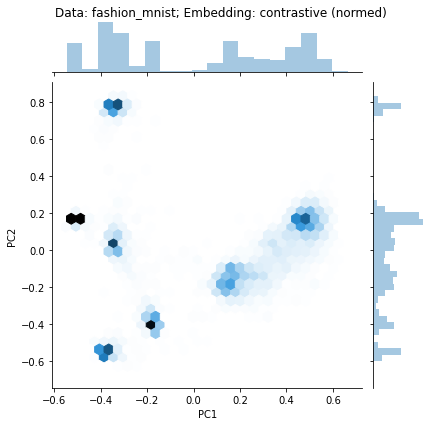

In [56]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
g.savefig('figs/Joint_PCA_plot_%s_contrastive_embed.png' % DATA)

In [57]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

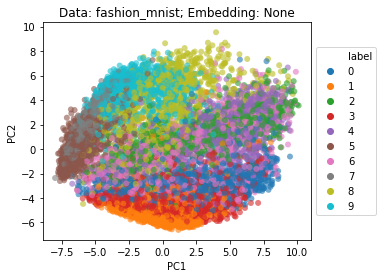

In [58]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_no_embed.png' % DATA)

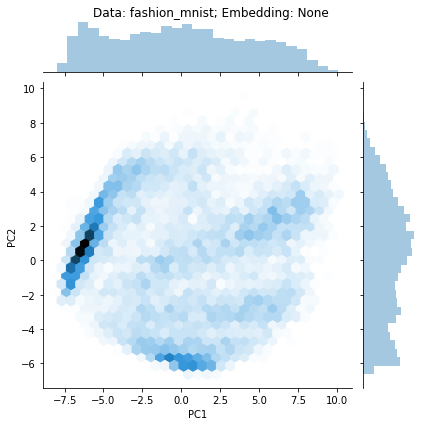

In [59]:
g = sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_no_embed.png' % DATA)

## Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [60]:
softmax = SoftmaxPred()

In [61]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [62]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [63]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [64]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)

    t_loss = cce_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_acc(y, y_preds)

In [65]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [66]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

Epoch 1, Loss: 1.6337740421295166, Acc: 88.85166931152344, Test Loss: 1.6069645881652832, Test Acc: 87.20999908447266
Epoch 2, Loss: 1.5743522644042969, Acc: 90.40166473388672, Test Loss: 1.5954796075820923, Test Acc: 87.84000396728516
Epoch 3, Loss: 1.563817024230957, Acc: 90.96833801269531, Test Loss: 1.5898040533065796, Test Acc: 88.1500015258789
Epoch 4, Loss: 1.5580235719680786, Acc: 91.3566665649414, Test Loss: 1.5862654447555542, Test Acc: 88.36000061035156
Epoch 5, Loss: 1.5543372631072998, Acc: 91.57833099365234, Test Loss: 1.5839604139328003, Test Acc: 88.41999816894531
Epoch 6, Loss: 1.5517377853393555, Acc: 91.7699966430664, Test Loss: 1.5822187662124634, Test Acc: 88.48999786376953
Epoch 7, Loss: 1.5497225522994995, Acc: 91.89166259765625, Test Loss: 1.5809427499771118, Test Acc: 88.55000305175781
Epoch 8, Loss: 1.548094391822815, Acc: 92.0050048828125, Test Loss: 1.5799208879470825, Test Acc: 88.55000305175781
Epoch 9, Loss: 1.5467480421066284, Acc: 92.09500122070312, Tes

In [40]:
test_acc.result().numpy() # default max margin contrastive loss

0.893

In [67]:
test_acc.result().numpy() # max margin contrastive loss (cosine)

0.8906